# Packages

In [1]:
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score,classification_report
from sklearn import metrics
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from numpy import mean, std
from collections import Counter
from sklearn.feature_selection import mutual_info_classif,f_classif
from sklearn.feature_selection import VarianceThreshold, SelectKBest 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib
from matplotlib.colors import ListedColormap
from sklearn.metrics import make_scorer,matthews_corrcoef, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Set the default text font size
plt.rc('font', size=12)# Set the axes title font size
plt.rc('axes', titlesize=12)# Set the axes labels font size
plt.rc('axes', labelsize=12)# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)# Set the legend font size
plt.rc('legend', fontsize=12)# Set the font size of the figure title
plt.rc('figure', titlesize=12)

# Data

In [3]:
df_preprocessed=pd.read_csv('df_after_preprocessing.csv',index_col=0)

final_variables=['BHWinstreak', 'BHLosestreak', 'BAWinstreak', 'BALosestreak', 'cHS',
       'cHF', 'cHY', 'cHR', 'r3FTHG', 'r3HC', 'r3HY', 'r3HR', 'r4HR', 'r5HR',
       'WinsOverH', 'LossesOverH', 'WinstreakH', 'LosestreakH', 'cAF', 'cAR',
       'r3AC', 'r3AF', 'r3AY', 'r3AR', 'r4AR', 'r5FTAG', 'r5AR', 'ewm03_xGA',
       'LoserateA', 'WinsOverA', 'LossesOverA', 'WinstreakA', 'LosestreakA',
       'RestH', 'RestYesNoH', 'FormationCatH', 'FormationChangeH', 'RestA',
       'RestYesNoA', 'FormationCatA', 'FormationChangeA', 'Markov_ratingH',
       'OD_ratingH', 'OD_ratingA', 'SpreadH', 'SpreadA', 'SpreadD', 'HomeAdv',
       'HomeAdv2', 'HomeAdv3', 'HAvgAge', 'HForeigner', 'AAvgAge',
       'AForeigner']
target=['FTR']

df=df_preprocessed[final_variables+target]

X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=10,window=20,forecast=8)

y_test_adh=y_test.copy()
y_train = LabelEncoder().fit_transform(y_train.values.ravel())
y_test = LabelEncoder().fit_transform(y_test.values.ravel())
print(Counter(y_train))
print(Counter(y_test))

Counter({2: 90, 0: 65, 1: 45})
Counter({2: 37, 0: 26, 1: 17})


# Functions

In [4]:
rps_scorer= make_scorer(functions.rps, needs_proba=True)
roc_auc_ovr_scorer = make_scorer(roc_auc_score, needs_proba=True,multi_class='ovr')
auprc= make_scorer(functions.multi_auprc, needs_proba=True, greater_is_better=True)

In [5]:
def run_classifier(clf, param_grid, title,X_train,y_train):
    # -----------------------------------------------------
    
    pipe = Pipeline([
    ('selector', SelectKBest()),
    ('classifier', clf)
    ])

    # -----------------------------------------------
    
    scoring = {"Accuracy": 'accuracy',"Log_loss":'neg_log_loss',"Precision":make_scorer(precision_score, average = 'macro'),'Recall': make_scorer(recall_score, average = 'macro'),
               'Matthews_corrcoef': make_scorer(matthews_corrcoef),'F1_score':'f1_macro',"AUC":roc_auc_ovr_scorer, 'RPS': rps_scorer}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipe, param_grid, cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1,verbose=1).fit(X_train, y_train)

    # -----------------------------------------------------
    print("The best parameters are %s" % (grid.best_params_)) 

    #y_pred = grid.best_estimator_.predict(X_test)
    #y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------

    joblib.dump(grid, 'grid_'+title+'.pkl')

    #------------------------------------------------


def classifier_plots(grid):
    #-----------------------------------------------------------
    
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------
    # CONFUSSION MATRIX
    #------------------------------------------------------

    fig, ax = plt.subplots(1, 1, figsize = (12,6))
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax)
    #ax.set_title("Macierz błędów")
    ax.set_xlabel("Klasa predykowana")
    ax.set_ylabel("Klasa rzeczywista")
    target_names=['Gość', 'Remis', 'Gospodarz']
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)
    fig.tight_layout()
    fig.savefig("rf_conf_matrix.jpg",bbox_inches='tight')
    plt.show()  

    # -----------------------------------------------------

    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred, average= 'weighted')*100))
    print('---------------------------------')

    #------------------------------------------------------------
    # ROC CURVES AND HISTOGRAMS
    #-----------------------------------------------------------
    
    classes = grid.classes_
    classes_names=['Gość', 'Remis', 'Gospodarz']

    plt.figure(figsize = (16,9))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}

    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        cn=classes_names[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = X_test.copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(cn)
        ax.legend([f"Klasa: {cn}", "Reszta"])
        ax.set_xlabel(f"P(x = {cn})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = functions.get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        functions.plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("Krzywa ROC OvR")
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
        
    plt.tight_layout()
    plt.savefig("rf_roc_auc.jpg",bbox_inches='tight')
    plt.show()

    # Displays the ROC AUC for each class
    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    print('---------------------------------')

# Decision Tree
### Starting from decision tree (max_depth=3)

In [7]:
pipe = Pipeline([
('classifier', DecisionTreeClassifier(max_depth=3,random_state=1))
])

pipe.fit(X_train, y_train)
 
print('Training set Accuracy: ' + str(pipe.score(X_train,y_train)))
print('Test set Accuracy: ' + str(pipe.score(X_test,y_test)))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Training set Accuracy: 0.675
Test set Accuracy: 0.4875
CV Mean Accuracy: 0.483 (0.043)


findfont: Font family ['default'] not found. Falling back to DejaVu Sans.


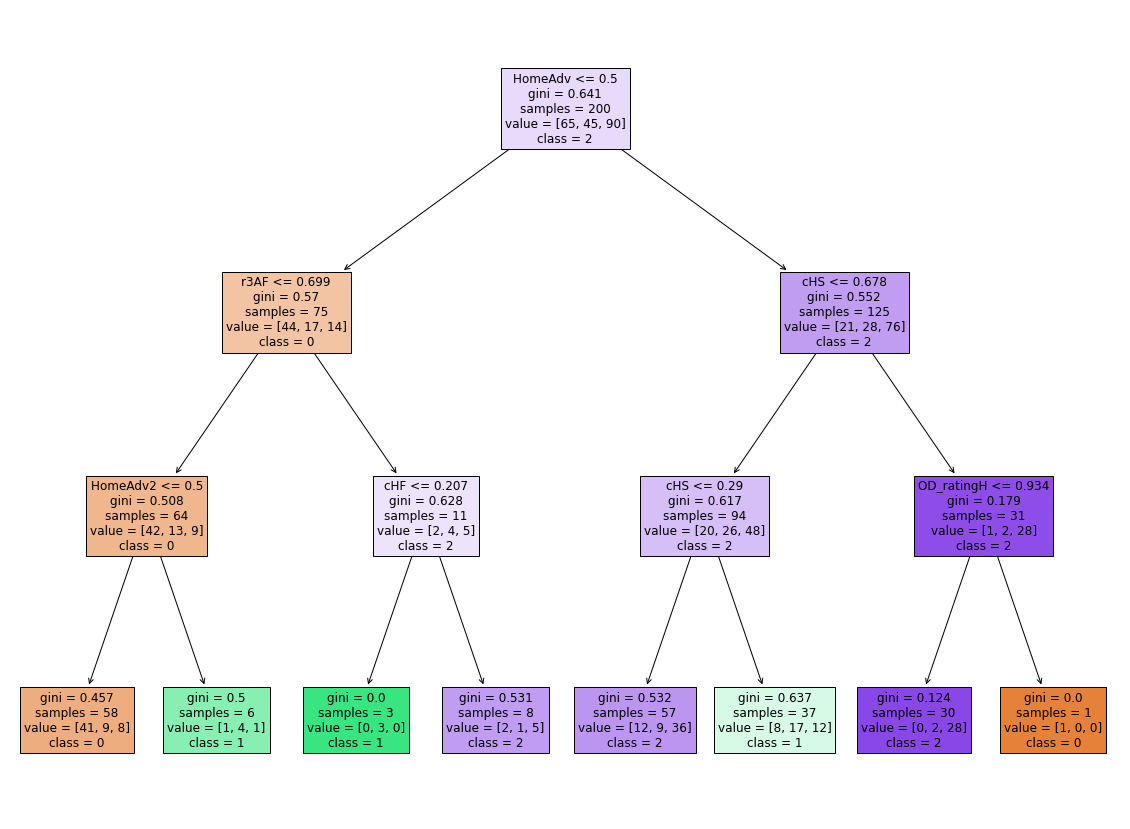

In [10]:
fig = plt.figure(figsize=(20,15))
_ = plot_tree(pipe['classifier'], feature_names=final_variables,  class_names=['0','1','2'],filled=True)

### (max_depth=None), problem with overfitting

In [11]:
pipe = Pipeline([
('classifier', DecisionTreeClassifier(random_state=1))
])

pipe.fit(X_train, y_train)
 
print('Training set Accuracy: ' + str(pipe.score(X_train,y_train)))
print('Test set Accuracy: ' + str(pipe.score(X_test,y_test)))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Training set Accuracy: 1.0
Test set Accuracy: 0.4125
CV Mean Accuracy: 0.425 (0.073)


In [12]:
text_representation = export_text(pipe['classifier'],feature_names=final_variables,  max_depth=5)
#print(text_representation)

### Overfitting problem for different ma depths

In [13]:
pipe = Pipeline([
('classifier', DecisionTreeClassifier(random_state=1))
])

parameters={
    'classifier__max_depth': list(range(2,20,2)),
    'classifier__random_state':[1]
    }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = GridSearchCV(pipe, parameters, scoring='accuracy',cv=cv,return_train_score=True).fit(X_train, y_train)
 
print('Training set Accuracy: ' + str(grid.score(X_train,y_train)))
print('Test set Accuracy: ' + str(grid.score(X_test,y_test)))

n_scores = cross_val_score(grid, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Training set Accuracy: 0.615
Test set Accuracy: 0.5875
CV Mean Accuracy: 0.552 (0.044)


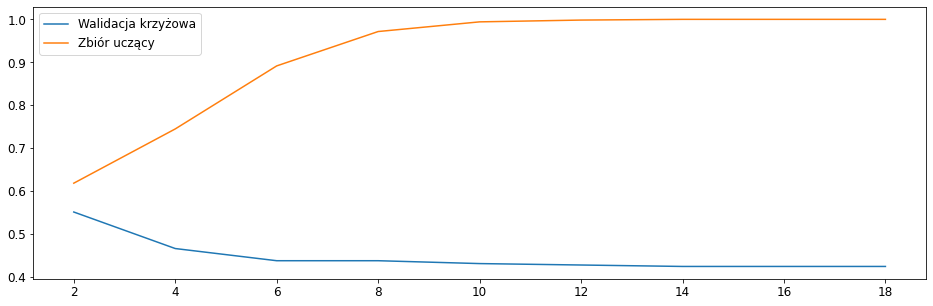

In [16]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')   

fig = plt.figure(figsize=(16,5))
plt.plot(result_df['param_classifier__max_depth'], result_df['mean_test_score'], label = "Walidacja krzyżowa")
plt.plot(result_df['param_classifier__max_depth'], result_df['mean_train_score'], label = "Zbiór uczący")
plt.legend()
plt.show()

### Confussion matrix for ma_depth=None

In [17]:
y_pred=grid.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[14  0 12]
 [ 6  0 11]
 [ 4  0 33]]
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        26
           1       0.00      0.00      0.00        17
           2       0.59      0.89      0.71        37

    accuracy                           0.59        80
   macro avg       0.39      0.48      0.42        80
weighted avg       0.46      0.59      0.51        80



# Random Forest
### basic model

In [18]:
pipe = Pipeline([
('classifier', RandomForestClassifier(random_state=1))
])

pipe.fit(X_train, y_train)
 
print('Training set Accuracy: ' + str(pipe.score(X_train,y_train)))
print('Test set Accuracy: ' + str(pipe.score(X_test,y_test)))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Training set Accuracy: 1.0
Test set Accuracy: 0.55
CV Mean Accuracy: 0.553 (0.052)


### Feature importance for basic model

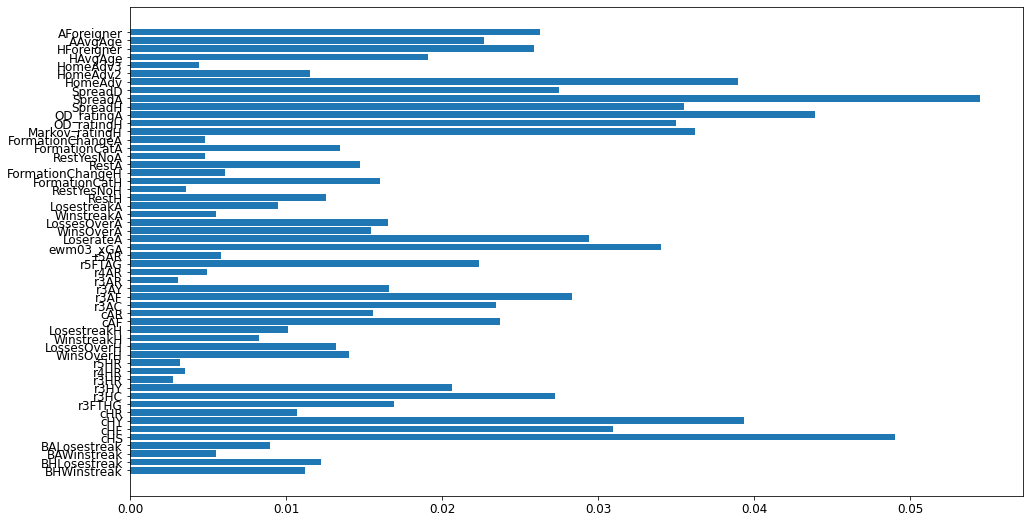

      Variable  Importances
45     SpreadA     0.054507
4          cHS     0.049052
43  OD_ratingA     0.043908
6          cHY     0.039380
47     HomeAdv     0.039005


In [19]:
rf_model=pipe['classifier']
importances=rf_model.feature_importances_

fig = plt.figure(figsize=(16,9))
df_importances=pd.DataFrame({'Variable':final_variables,'Importances':importances})
plt.barh(final_variables, importances)
plt.show()

print(df_importances.sort_values('Importances',ascending=False).head(5))

### Only 5 most important variables from previous model

In [20]:
variables=list(df_importances.sort_values('Importances',ascending=False).head(5)['Variable'])
X_train_3=X_train[variables]
X_test_3=X_test[variables]

pipe = Pipeline([
('classifier', RandomForestClassifier(random_state=1))
])

pipe.fit(X_train_3, y_train)
 
print('Training set Accuracy: ' + str(pipe.score(X_train_3,y_train)))
print('Test set Accuracy: ' + str(pipe.score(X_test_3,y_test)))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipe, X_train_3, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Training set Accuracy: 1.0
Test set Accuracy: 0.5625
CV Mean Accuracy: 0.553 (0.077)


# Pipeline
### Tuning hiperparameter

### First randomsearch

In [25]:
max_depth = [int(x) for x in np.linspace(5, 110, num = 21)]
max_depth.append(None)

parameters = {
    'selector__score_func': [f_classif, mutual_info_classif],
    'selector__k': [5,10,20,54],
    'classifier__n_estimators' : [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_depth': max_depth,
    'classifier__max_leaf_nodes': [3, 6, 9],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__bootstrap': [True, False],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__random_state':[1]
}

clf = RandomForestClassifier()

pipe = Pipeline([
('selector', SelectKBest()),
('classifier', clf)
])

# -----------------------------------------------

scoring = {"Accuracy": 'accuracy'}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = RandomizedSearchCV(pipe, parameters, cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1,random_state=1).fit(X_train, y_train)

# -----------------------------------------------------
print("The best parameters are %s" % (grid.best_params_)) 
print('Training set Accuracy: ' + str(grid.score(X_train,y_train)))
print('Test set Accuracy: ' + str(grid.score(X_test,y_test)))
print('CV Mean Accuracy: %.3f ' % (grid.best_score_))

The best parameters are {'selector__score_func': <function mutual_info_classif at 0x000002B288F1D900>, 'selector__k': 20, 'classifier__random_state': 1, 'classifier__n_estimators': 250, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_leaf_nodes': 3, 'classifier__max_features': None, 'classifier__max_depth': 104, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Training set Accuracy: 0.605
Test set Accuracy: 0.5625
CV Mean Accuracy: 0.585 


### gridsearch

In [26]:
parameters = {
    'selector__score_func': [mutual_info_classif],
    'selector__k': [15,20,25],
    'classifier__n_estimators':[200,250,300],
    'classifier__max_features': [None],
    'classifier__max_depth': [100,104,108],
    'classifier__max_leaf_nodes': [2,3,4],
    'classifier__criterion': ['gini'],
    'classifier__bootstrap': [True],
    'classifier__min_samples_split': [4,5,6],
    'classifier__min_samples_leaf': [3,4,5],
    'classifier__random_state':[1]
}

rf = RandomForestClassifier()

run_classifier(clf=rf, param_grid=parameters, title='Random_Forest_20kolejek',X_train=X_train,y_train=y_train)

Fitting 15 folds for each of 729 candidates, totalling 10935 fits
The best parameters are {'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': 100, 'classifier__max_features': None, 'classifier__max_leaf_nodes': 3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 200, 'classifier__random_state': 1, 'selector__k': 20, 'selector__score_func': <function mutual_info_classif at 0x000002B288F1D900>}


In [6]:
grid=joblib.load('grid_Random_Forest_20kolejek.pkl')

In [7]:
grid.best_params_

{'classifier__bootstrap': True,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 100,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': 3,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 4,
 'classifier__n_estimators': 200,
 'classifier__random_state': 1,
 'selector__k': 20,
 'selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [14]:
estimator=grid.best_estimator_['classifier'].estimators_[1]
estimator

DecisionTreeClassifier(max_depth=100, max_leaf_nodes=3, min_samples_leaf=4,
                       min_samples_split=4, random_state=2135392491)

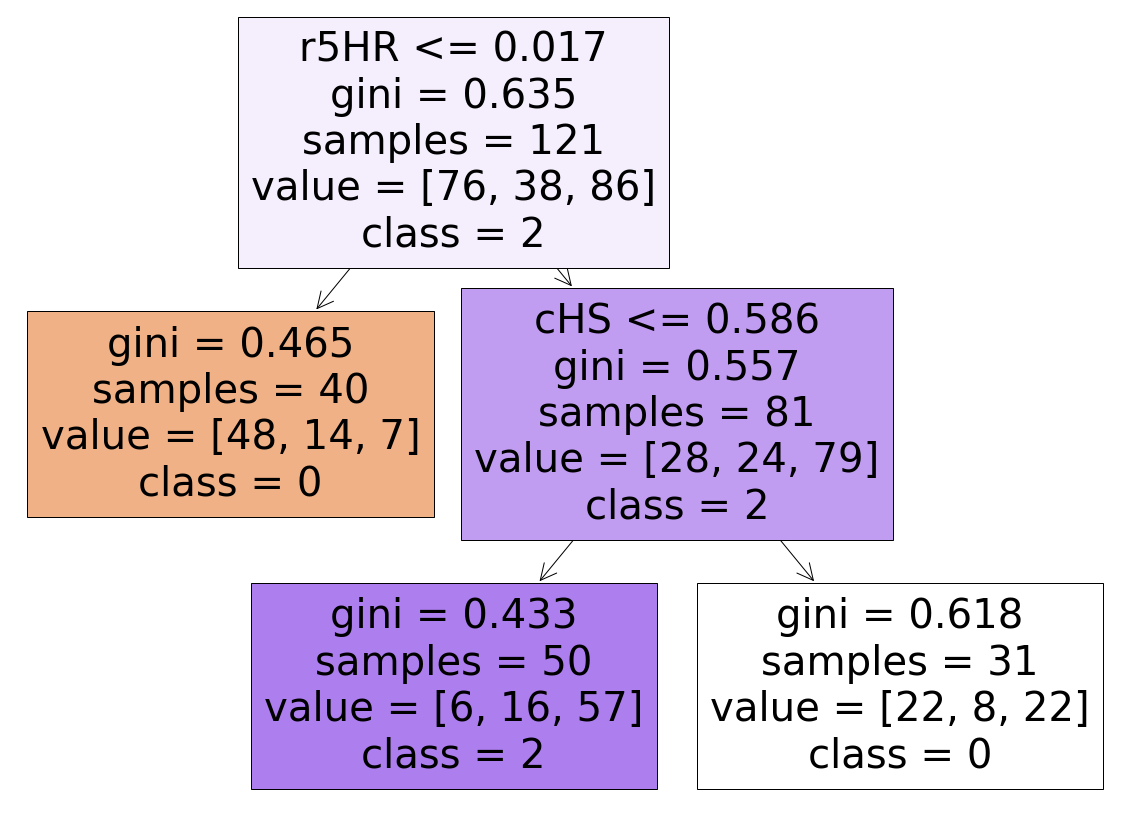

In [15]:
fig = plt.figure(figsize=(20,15))
_ = plot_tree(estimator, feature_names=final_variables,  class_names=['0','1','2'],filled=True)

In [19]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')   
result_df=result_df[(result_df['param_classifier__bootstrap']==True)]
result_df=result_df[(result_df['param_classifier__criterion']=='gini')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__bootstrap,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,...,split8_test_RPS,split9_test_RPS,split10_test_RPS,split11_test_RPS,split12_test_RPS,split13_test_RPS,split14_test_RPS,mean_test_RPS,std_test_RPS,rank_test_RPS
0,0.640287,0.071186,0.061370,0.011504,True,gini,100,None,2,3,...,0.202761,0.227140,0.210502,0.178366,0.200707,0.183193,0.212317,0.196437,0.016987,225
1,0.556977,0.012493,0.054454,0.003107,True,gini,100,None,2,3,...,0.202761,0.227140,0.209989,0.183456,0.201149,0.182446,0.212261,0.196958,0.016123,57
2,0.587961,0.028647,0.055585,0.005900,True,gini,100,None,2,3,...,0.202577,0.227140,0.210065,0.182454,0.200573,0.182494,0.211975,0.196732,0.016161,148
3,0.645806,0.019896,0.064494,0.003524,True,gini,100,None,2,3,...,0.205002,0.227759,0.210069,0.181460,0.199619,0.183174,0.211506,0.196888,0.016500,77
4,0.648665,0.013885,0.066289,0.004829,True,gini,100,None,2,3,...,0.203187,0.227759,0.210266,0.179304,0.199923,0.184149,0.211384,0.196791,0.016284,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.685168,0.017205,0.063962,0.004053,True,gini,108,None,4,5,...,0.202535,0.227186,0.204599,0.176427,0.194394,0.177002,0.215487,0.193542,0.019026,718
725,0.670074,0.012641,0.063032,0.004107,True,gini,108,None,4,5,...,0.201656,0.225413,0.210508,0.182564,0.194100,0.180909,0.213107,0.195579,0.016639,253
726,0.724729,0.024345,0.073869,0.005565,True,gini,108,None,4,5,...,0.200633,0.225400,0.203311,0.181340,0.195728,0.180566,0.216638,0.194453,0.018313,542
727,0.776922,0.025890,0.072606,0.003926,True,gini,108,None,4,5,...,0.201051,0.226341,0.206950,0.183811,0.195312,0.182599,0.211273,0.194505,0.016740,525


In [18]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')  
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__bootstrap,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,...,split8_test_RPS,split9_test_RPS,split10_test_RPS,split11_test_RPS,split12_test_RPS,split13_test_RPS,split14_test_RPS,mean_test_RPS,std_test_RPS,rank_test_RPS
0,0.640287,0.071186,0.061370,0.011504,True,gini,100,None,2,3,...,0.202761,0.227140,0.210502,0.178366,0.200707,0.183193,0.212317,0.196437,0.016987,225
1,0.556977,0.012493,0.054454,0.003107,True,gini,100,None,2,3,...,0.202761,0.227140,0.209989,0.183456,0.201149,0.182446,0.212261,0.196958,0.016123,57
2,0.587961,0.028647,0.055585,0.005900,True,gini,100,None,2,3,...,0.202577,0.227140,0.210065,0.182454,0.200573,0.182494,0.211975,0.196732,0.016161,148
3,0.645806,0.019896,0.064494,0.003524,True,gini,100,None,2,3,...,0.205002,0.227759,0.210069,0.181460,0.199619,0.183174,0.211506,0.196888,0.016500,77
4,0.648665,0.013885,0.066289,0.004829,True,gini,100,None,2,3,...,0.203187,0.227759,0.210266,0.179304,0.199923,0.184149,0.211384,0.196791,0.016284,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.685168,0.017205,0.063962,0.004053,True,gini,108,None,4,5,...,0.202535,0.227186,0.204599,0.176427,0.194394,0.177002,0.215487,0.193542,0.019026,718
725,0.670074,0.012641,0.063032,0.004107,True,gini,108,None,4,5,...,0.201656,0.225413,0.210508,0.182564,0.194100,0.180909,0.213107,0.195579,0.016639,253
726,0.724729,0.024345,0.073869,0.005565,True,gini,108,None,4,5,...,0.200633,0.225400,0.203311,0.181340,0.195728,0.180566,0.216638,0.194453,0.018313,542
727,0.776922,0.025890,0.072606,0.003926,True,gini,108,None,4,5,...,0.201051,0.226341,0.206950,0.183811,0.195312,0.182599,0.211273,0.194505,0.016740,525


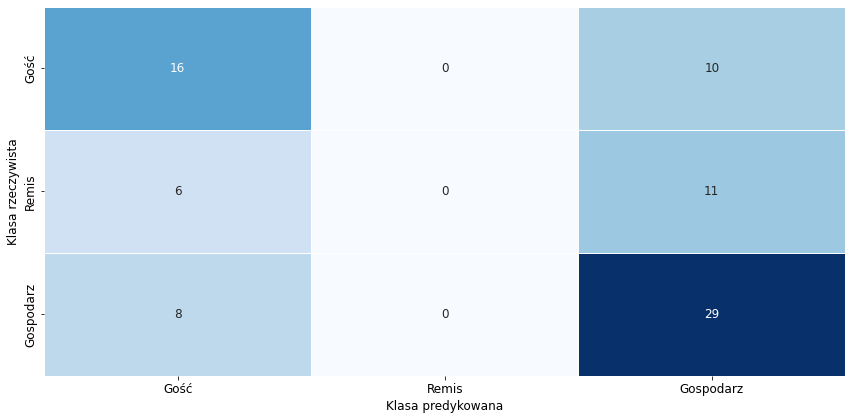

Accuracy score: 56.25%
Precision score: 44.16%
Recall score: 56.25%
---------------------------------


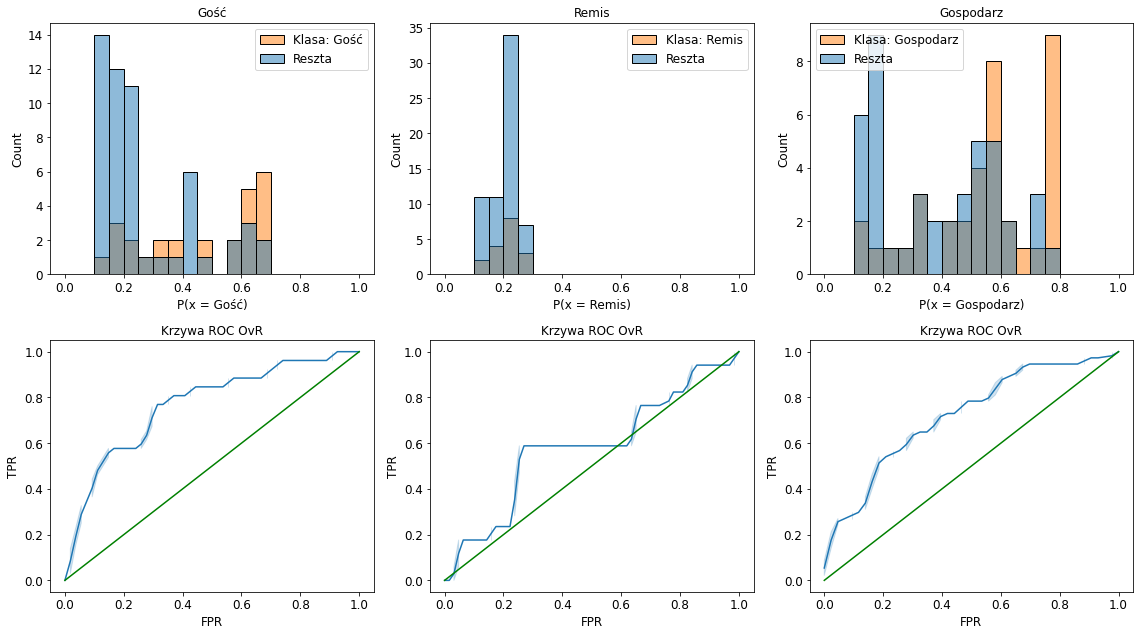

0 ROC AUC OvR: 0.7671
1 ROC AUC OvR: 0.5826
2 ROC AUC OvR: 0.7197
average ROC AUC OvR: 0.6898
---------------------------------


In [6]:
grid=joblib.load('grid_Random_Forest_20kolejek.pkl')

classifier_plots(grid)

In [8]:
grid.best_score_

0.5916666666666667

In [50]:
functions.grid_to_predictions(grid,'Random_Forest_20kolejek',y_test_adh,X_test)

### Check outcomes for different number of trees

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in list(range(0,500,50)):
        # create name for model
        key = '%.4f' % p
        models[key] = RandomForestClassifier()
        
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 
# define dataset
X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()